#### Script to extract tables from advice PDFs

Camelot works much better to identify the tables correctly compared to tabula, but some tweaks are needed. Especially, line_scale is required as some lines are too small for the default reader.

Problems
1. The case when there is a range and no single value is given (e.g. advice in sol.27.4)
2. Unknown behaviour: camelot doesn't recognize some cells (e.g. before 1990 in sol.27.7d)

In [237]:
import os
# import tabula
import pandas as pd
import PyPDF2
import re
import camelot
import numpy as np

In [157]:
stockA = pd.read_csv("../data/stockAssesment2022/StockAssessment.csv")

C:\Users\isaldiviagonzatti\AppData\Local\Temp\ipykernel_2504\3791297337.py:1: DtypeWarning: Columns (55,63,98,99,101,102,104,105,107,108,110,111,113,114,116,117,119,120,122,123,125,126,128,129,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  stockA = pd.read_csv("../data/stockAssesment2020/StockAssessment.csv")


In [158]:
stockA[stockA['StockDescription'].str.contains("Blue ling")].StockDescription.unique()

array(['Blue ling (Molva dypterygia) in subareas 6-7 and Division 5.b (Celtic Seas and Faroes grounds)'],
      dtype=object)

In [1745]:
# read files in directory
os.listdir('../dataTemp/icesAdvice/')

['bss.27.4bc7ad-h.csv',
 'bss.27.8ab.csv',
 'san.sa.1r.csv',
 'san.sa.2r.csv',
 'sol.27.20-24.csv',
 'sol.27.4.csv',
 'sol.27.7a.csv',
 'sol.27.7d.csv',
 'sol.27.7e.csv',
 'sol.27.7fg.csv',
 'sol.27.8ab.csv',
 'spr.27.3a.csv',
 'spr.27.3a4.csv',
 'spr.27.3a4bis.csv',
 'spr.27.4.csv']

In [1785]:
fishStock = 'san.sa.1r' 

In [1786]:
# get page number in which Table 6 lies, and also get the next one as tables can span two oages
obj = PyPDF2.PdfFileReader("../data/pdfsICES/{}.pdf".format(fishStock))

pgno = obj.getNumPages()

#in some pdfs the Table 6 has more than one space between Table and 6
s = "Table[ ]{1,}6" 

for i in range(0, pgno):
    PgOb = obj.getPage(i)
    Text = PgOb.extractText()
    if re.search(s,Text):
         pages=str(i+1) + ',' + str(i+2)
         print(pages)

4,5


In [1787]:
# from camelot import utils
# layout, dim = utils.get_page_layout(r'C:\Users\isaldiviagonzatti\Downloads\pdfsICES\spr.27.3a4.pdf')

In [1788]:
# read tables with Camelot. Using backend="poppler" as Ghostscript is not working for me
# table_area is not providing the expected results
# iterations had no effect for me
tables = camelot.read_pdf("../data/pdfsICES/{}.pdf".format(fishStock), 
                           pages=pages, 
                           backend="poppler", 
                           # flavor='stream',
                           # # table_areas accepts strings of the form x1,y1,x2,y2 where (x1, y1) -> top-left and (x2, y2)
                           # table_area=['0,600,590,700'],
                           # iterations=1,
                           line_scale=30,
                           # split_text=True,
                           strip_text=['#','^','<', '-', '≤', '***', '\n'],
                          )
print("Total tables extracted:", tables.n)

Total tables extracted: 7


In [1789]:
# delete tables before the first table in list that corresponds to table 6 (Advice) 
firstAdvice = [i for i, elem in enumerate(tables) if 'ICES advice' \
    in tables[i].df.iloc[0,:].to_list()][0]
tables = tables[firstAdvice:]

In [1790]:
# filter tables by two conditions:
# [0][0] is numeric and len(columns) is equal to the len(first table 6) 
# or the first row is equal to the first row of the first table 6

filterTableSix = [i for i, elem in enumerate(tables) if (pd.to_numeric\
    (tables[i].df[0].str.extract('(\d+)')[0][0], errors='coerce') > 0\
    and len(tables[i].df.columns) == len(tables[0].df.columns))\
    or tables[i].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True
]

tableSix = [tables[i].df for i in filterTableSix]
tableSix = pd.concat(tableSix).reset_index(drop=True)

In [1914]:
# fix table 
icesTable = tableSix.copy()
icesTable.columns = icesTable.iloc[0,:]
icesTable = icesTable[1:].reset_index(drop=True)
icesTable['fishStock'] = fishStock
# sometimes the columns Year and ICES advice (text) don't split, we strip the text
icesTable['Year'] = icesTable['Year'].str.extract('(\d+)', expand=False)
icesTable = icesTable[icesTable['Year'].astype(str).str.isnumeric()]

# sometimes there is more than one space between the words in the columns
icesTable.rename(columns=lambda x: re.sub(r' +', ' ', x).strip(), inplace=True) # '[^a-zA-Z]+'

# replace columns names
dictCol = {'(?=.*[Cc]atch)(?=.*[Aa]dvice)': 'SAD', 
            '(?=.*[Ll]anding)(?=.*[Aa]dvice)': 'SAD_landing',
            '(?=.*TAC)': 'TAC',
            '(?=.*ICES)(?=.*[Ll]anding)': 'Landings',
            '(?=.*ICES)(?=.*[Cc]atch)': 'Catches (stockass)'} 

# if more than one column name matches the regex, we don't rename them
    
for key, value in dictCol.items():
    countCol = []
    for i in range(len(icesTable.columns.to_list())):
        count = bool(re.search(key, icesTable.columns[i]))
        countCol.append(count)
    if countCol.count(True) == 1:
        for i in range(len(icesTable.columns.to_list())):
            if bool(re.search(key, icesTable.columns[i])) == True:
                icesTable.rename(columns = {icesTable.columns[i]:value}, inplace = True)

# fix numeric columns
numericCol = ['SAD', 'SAD_landings', 'TAC', 'Landings', 'Year', 'Catches (stockass)']
for col in icesTable.columns:
    if col in numericCol:
        # strip spaces between numbers
        icesTable[col] = icesTable[col].replace({' ': ''}, regex=True)
        # for cases in which there is an explanation of the number, we strip it
        icesTable[col] = icesTable[col].str.split('(').str[0]
        icesTable[col] = icesTable[col].apply(pd.to_numeric, errors='coerce')

icesTable = icesTable.replace({'': np.nan})
# icesTable = icesTable.apply(pd.to_numeric, errors='coerce').fillna(icesTable)

icesTable.reset_index(drop=True, inplace=True)
icesTable

,Year,ICES advice,SAD,TAC,ICES catch SA 1,ICES catch SA 1r,Total ICES catch (SAs 1r–7r),fishStock
0,2005,Exploitation to be kept below the level of 200...,NaN,661000.0,104000,NaN,177000,san.sa.1r
1,2006,The fishery should remain closed until informa...,NaN,300000.0,238000,NaN,293000,san.sa.1r
2,2007,The fishery should remain closed until informa...,NaN,173000.0,109000,NaN,230000,san.sa.1r
3,2008,The fishery should only be allowed if monitori...,NaN,375000.0,239000,NaN,348000,san.sa.1r
4,2009,The fishery should only be allowed if monitori...,NaN,377000.0,309000,NaN,353000,san.sa.1r
5,2010,The fishery should only be allowed if monitori...,NaN,377000.0,301000,NaN,414000,san.sa.1r
6,2011,MSY approach: allow for sufficient stock (MSY ...,320000.0,320000.0,312000,NaN,438000,san.sa.1r
7,2012,MSY approach: allowfor sufficient stock (MSY B...,23000.0,23000.0,46000,NaN,102000,san.sa.1r
8,2013,MSY approach: allow for sufficient stock (MSY ...,224544.0,225000.0,210000,NaN,278000,san.sa.1r
9,2014,MSY approach: allow for sufficient stock (MSY ...,57000.0,57000.0,99000,NaN,264000,san.sa.1r


In [1915]:
# Sandeel case
if 'san.sa' in fishStock:
    icesTable = icesTable.loc[:, ~icesTable.columns.str.contains('(?=.*[Tt]otal)(?=.*[Cc]atch)')]
    icesCatches = icesTable.columns.str.contains('(?=.*ICES)(?=.*[Cc]atch)')
    icesTable.iloc[:,np.where(icesCatches)[0][1]].fillna(icesTable.iloc[:,np.where(icesCatches)[0][0]], inplace=True)
    icesTable = icesTable.drop(columns=[icesTable.iloc[:,np.where(icesCatches)[0][0]].name])
    icesTable = icesTable.rename(columns={icesTable.iloc[:,np.where(icesCatches)[0][0]].name: 'Catches (stockass)'})
icesTable

,Year,ICES advice,SAD,TAC,Catches (stockass),fishStock
0,2005,Exploitation to be kept below the level of 200...,NaN,661000.0,104000,san.sa.1r
1,2006,The fishery should remain closed until informa...,NaN,300000.0,238000,san.sa.1r
2,2007,The fishery should remain closed until informa...,NaN,173000.0,109000,san.sa.1r
3,2008,The fishery should only be allowed if monitori...,NaN,375000.0,239000,san.sa.1r
4,2009,The fishery should only be allowed if monitori...,NaN,377000.0,309000,san.sa.1r
5,2010,The fishery should only be allowed if monitori...,NaN,377000.0,301000,san.sa.1r
6,2011,MSY approach: allow for sufficient stock (MSY ...,320000.0,320000.0,312000,san.sa.1r
7,2012,MSY approach: allowfor sufficient stock (MSY B...,23000.0,23000.0,46000,san.sa.1r
8,2013,MSY approach: allow for sufficient stock (MSY ...,224544.0,225000.0,210000,san.sa.1r
9,2014,MSY approach: allow for sufficient stock (MSY ...,57000.0,57000.0,99000,san.sa.1r


In [1916]:
icesTable = icesTable[icesTable.Year != 2008]

In [1917]:
# check if all years were read correctly by Camelot
checkYear = pd.Series(np.arange(icesTable.Year.iloc[0], icesTable.Year.iloc[-1]+1))
missingYear = checkYear[~checkYear.isin(icesTable.Year)].to_list()
if missingYear:
    allYears = pd.DataFrame(list(range(min(icesTable.Year), max(icesTable.Year+1))), columns=['Year'])
    icesTable = icesTable.merge(allYears, how='outer', on='Year').sort_values(by='Year').reset_index(drop=True)
    icesTable['missingYear'] = np.where(icesTable.fishStock.isnull(),'missing', '')
    print('Years', missingYear, 'were not read correctly')
else:
    print('All years were read correctly')

Years [2008] were not read correctly


In [1771]:
# check for years that were not read because there is a SAD range 
specialYear = []
for value in range(len(icesTable['SAD']))[1:-1]:
        if np.isnan(icesTable['SAD'][value])\
        and ~np.isnan(icesTable['SAD'][value-1])\
        and ~np.isnan(icesTable['SAD'][value+1]): 
            specialYear.append(value)
if specialYear != []:
    print('Year(s)', icesTable['Year'][specialYear], 'is a special case')
else:
    print('All years have a specific SAD value')

All years have a specific SAD value


In [1772]:
# add columns from excel and reorganize
excelTable = (icesTable.reindex(['fishStock', 'Most recent assessment with corresponding report',
 'Year','Catches (stockass)', 'SAD','TAC', 'Catches (pdfs)','done?', 'report','Landings','SAD_landings'], axis=1))
    
# icesTable = icesTable.replace('','N/A')
excelTable.set_index('fishStock', inplace=True)
excelTable.to_csv("../dataTemp/icesAdvice/{}.csv".format(fishStock))
excelTable

,Most recent assessment with corresponding report,Year,Catches (stockass),SAD,TAC,Catches (pdfs),done?,report,Landings,SAD_landings
fishStock,,,,,,,,,,
spr.27.3a4,NaN,2019-01-01,NaN,138726,151940.0,NaN,NaN,NaN,137499.0,NaN
spr.27.3a4,NaN,2020-01-01,NaN,207807,207807.0,NaN,NaN,NaN,181991.0,NaN
spr.27.3a4,NaN,2021-01-01,NaN,106715,106715.0,NaN,NaN,NaN,80196.0,NaN
spr.27.3a4,NaN,2022-01-01,NaN,68690,NaN,NaN,NaN,NaN,NaN,NaN


In [1773]:
# sum of spr.27.3a and spr.27.4 
spr4 = pd.read_csv("../dataTemp/icesAdvice/spr.27.4.csv")
spr3a = pd.read_csv("../dataTemp/icesAdvice/spr.27.3a.csv")
col_list = spr3a.columns.tolist()
spr4, spr3a = (df.set_index(['Year']).drop(columns=['fishStock']) for df in [spr4, spr3a])
spr3aHist = spr3a.add(spr4, fill_value=0)
spr3aHist['fishStock'] = 'spr.27.3a4'
spr3aHist.reset_index(inplace=True)
spr3aHist = spr3aHist[col_list]
spr3aHist.to_csv("../dataTemp/icesAdvice/spr.27.3a4bis.csv", index=False)

In [1780]:
# concat all the stock extracted
listStock = os.listdir('../dataTemp/icesAdvice/')
listStock = [ '../dataTemp/icesAdvice/' + s for s in listStock]
listStock
allStock = pd.DataFrame()
allStock = pd.concat([pd.read_csv(f) for f in listStock ])
allStock.to_csv( "../dataTemp/adviceExtract.csv", index=False)

C:\Users\isaldiviagonzatti\AppData\Local\Temp\ipykernel_2504\3259206825.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  camelot.plot(tables[0], kind='text').show()


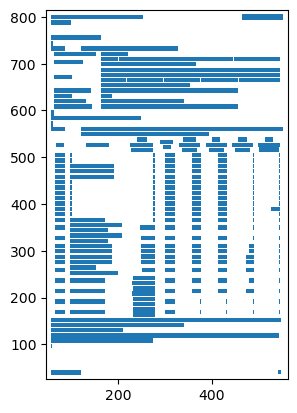

In [940]:
camelot.plot(tables[0], kind='text').show()

#### Trash

In [ ]:
# if len(tables) > 1:
#     # if table in same page is divided in two, then concatenate
#     if pd.to_numeric(tables[1].df[0][0], errors='coerce')> 0:
#         tableSix = pd.concat([tables[0].df, tables[1].df])
#     # if table is divided in two pages, then concatenate
#     elif tables[1].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True:
#         tableSix = pd.concat([tables[0].df, tables[1].df])
#     else:
#         tableSix = tables[0].df
# if len(tables) > 2:
#     # if table is divided in two pages, then concatenate
#     if tables[2].df.iloc[0,:].equals(tables[0].df.iloc[0,:]) == True:
#         tableSix = pd.concat([tableSix, tables[2].df])
#     elif pd.to_numeric(tables[2].df[0][0], errors='coerce')> 0:
#         tableSix = pd.concat([tableSix, tables[2].df])
        
# tableSix

#### From tabula

In [162]:
# tables = tabula.read_pdf(r"C:\Users\isaldiviagonzatti\Downloads\pdfsICES\spr.27.3a4.pdf", multiple_tables=True, 
#                           pages=page, lattice=True, guess=True, java_options="-Dfile.encoding=UTF8")                        


In [159]:
# tabula.convert_into("file:///C:/Users/isaldiviagonzatti/OneDrive%20-%20Kiel%20Institut%20f%C3%BCr%20Weltwirtschaft/Documents/General/Ignacio/data/pdf_ices_test/bli.27.5b67.pdf", r"C:/Users/isaldiviagonzatti//Downloads/test.csv", output_format="csv", stream=True, pages='4')

In [ ]:
# i=1
# for table in tables:
#     table.columns = table.iloc[0]
#     table = table.reindex(table.index.drop(0)).reset_index(drop=True)
#     table.columns.name = None
#     #To write Excel
#     table.to_excel('output'+str(i)+'.xlsx',header=True,index=False)
#     #To write CSV
#     table.to_csv('output'+str(i)+'.csv',sep='|',header=True,index=False)
#     i=i+1